aaaaaa

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.cascade_property_vectorizer import get_vector_from_string

In [2]:
# Set parameters
file_path = "./data/no_padding/single/single-data-1732743578421047000.csv"
chunk_size = 1000
test_size = 0.2
random_state = 42

In [3]:
# Initialize lists for collecting data 
X_all = [] 
r_all = []  
s_all = []

# Read and process data in chunks 
print("Reading and processing data...") 
for chunk in pd.read_csv(file_path, chunksize=chunk_size, delimiter=";"):     
    X_chunk = np.array([get_vector_from_string(row) for row in chunk['concatenated_bitstrings']])
    print(X_chunk.shape)
    
    r_chunk = chunk['num_included'].values
    s_chunk = chunk['num_excluded'].values

    # Compute theoretical "optimal_k"
    optimal_k = r_chunk*np.sqrt(0.5)/s_chunk
    optimal_k = np.log2(1.0/optimal_k)
    #optimal_k = r_chunk/s_chunk
    optimal_k = optimal_k.reshape(-1, 1)  # Reshape to make it a column vector
    #print(optimal_k)

    # Add "optimal_k" as a new column to X_chunk
    X_chunk = np.hstack((X_chunk, optimal_k))
    
    X_all.append(X_chunk)
    r_all.append(r_chunk)
    s_all.append(s_chunk)

Reading and processing data...
(1000, 9)


In [4]:
X = np.vstack(X_all)
r = np.concatenate(r_all)
s = np.concatenate(s_all)

In [5]:
feature_names = [
    'Total Size', 'Num Filters', 'Filter1 Size', 
    'Filter2 Size', 'Filter3 Size', 'Filter1 Set Bits',
    'Filter2 Set Bits', 'Filter3 Set Bits', 'F1 F2 Ratio', 'Optimal k'
]
df = pd.DataFrame(X, columns=feature_names)

<Figure size 2000x1500 with 0 Axes>

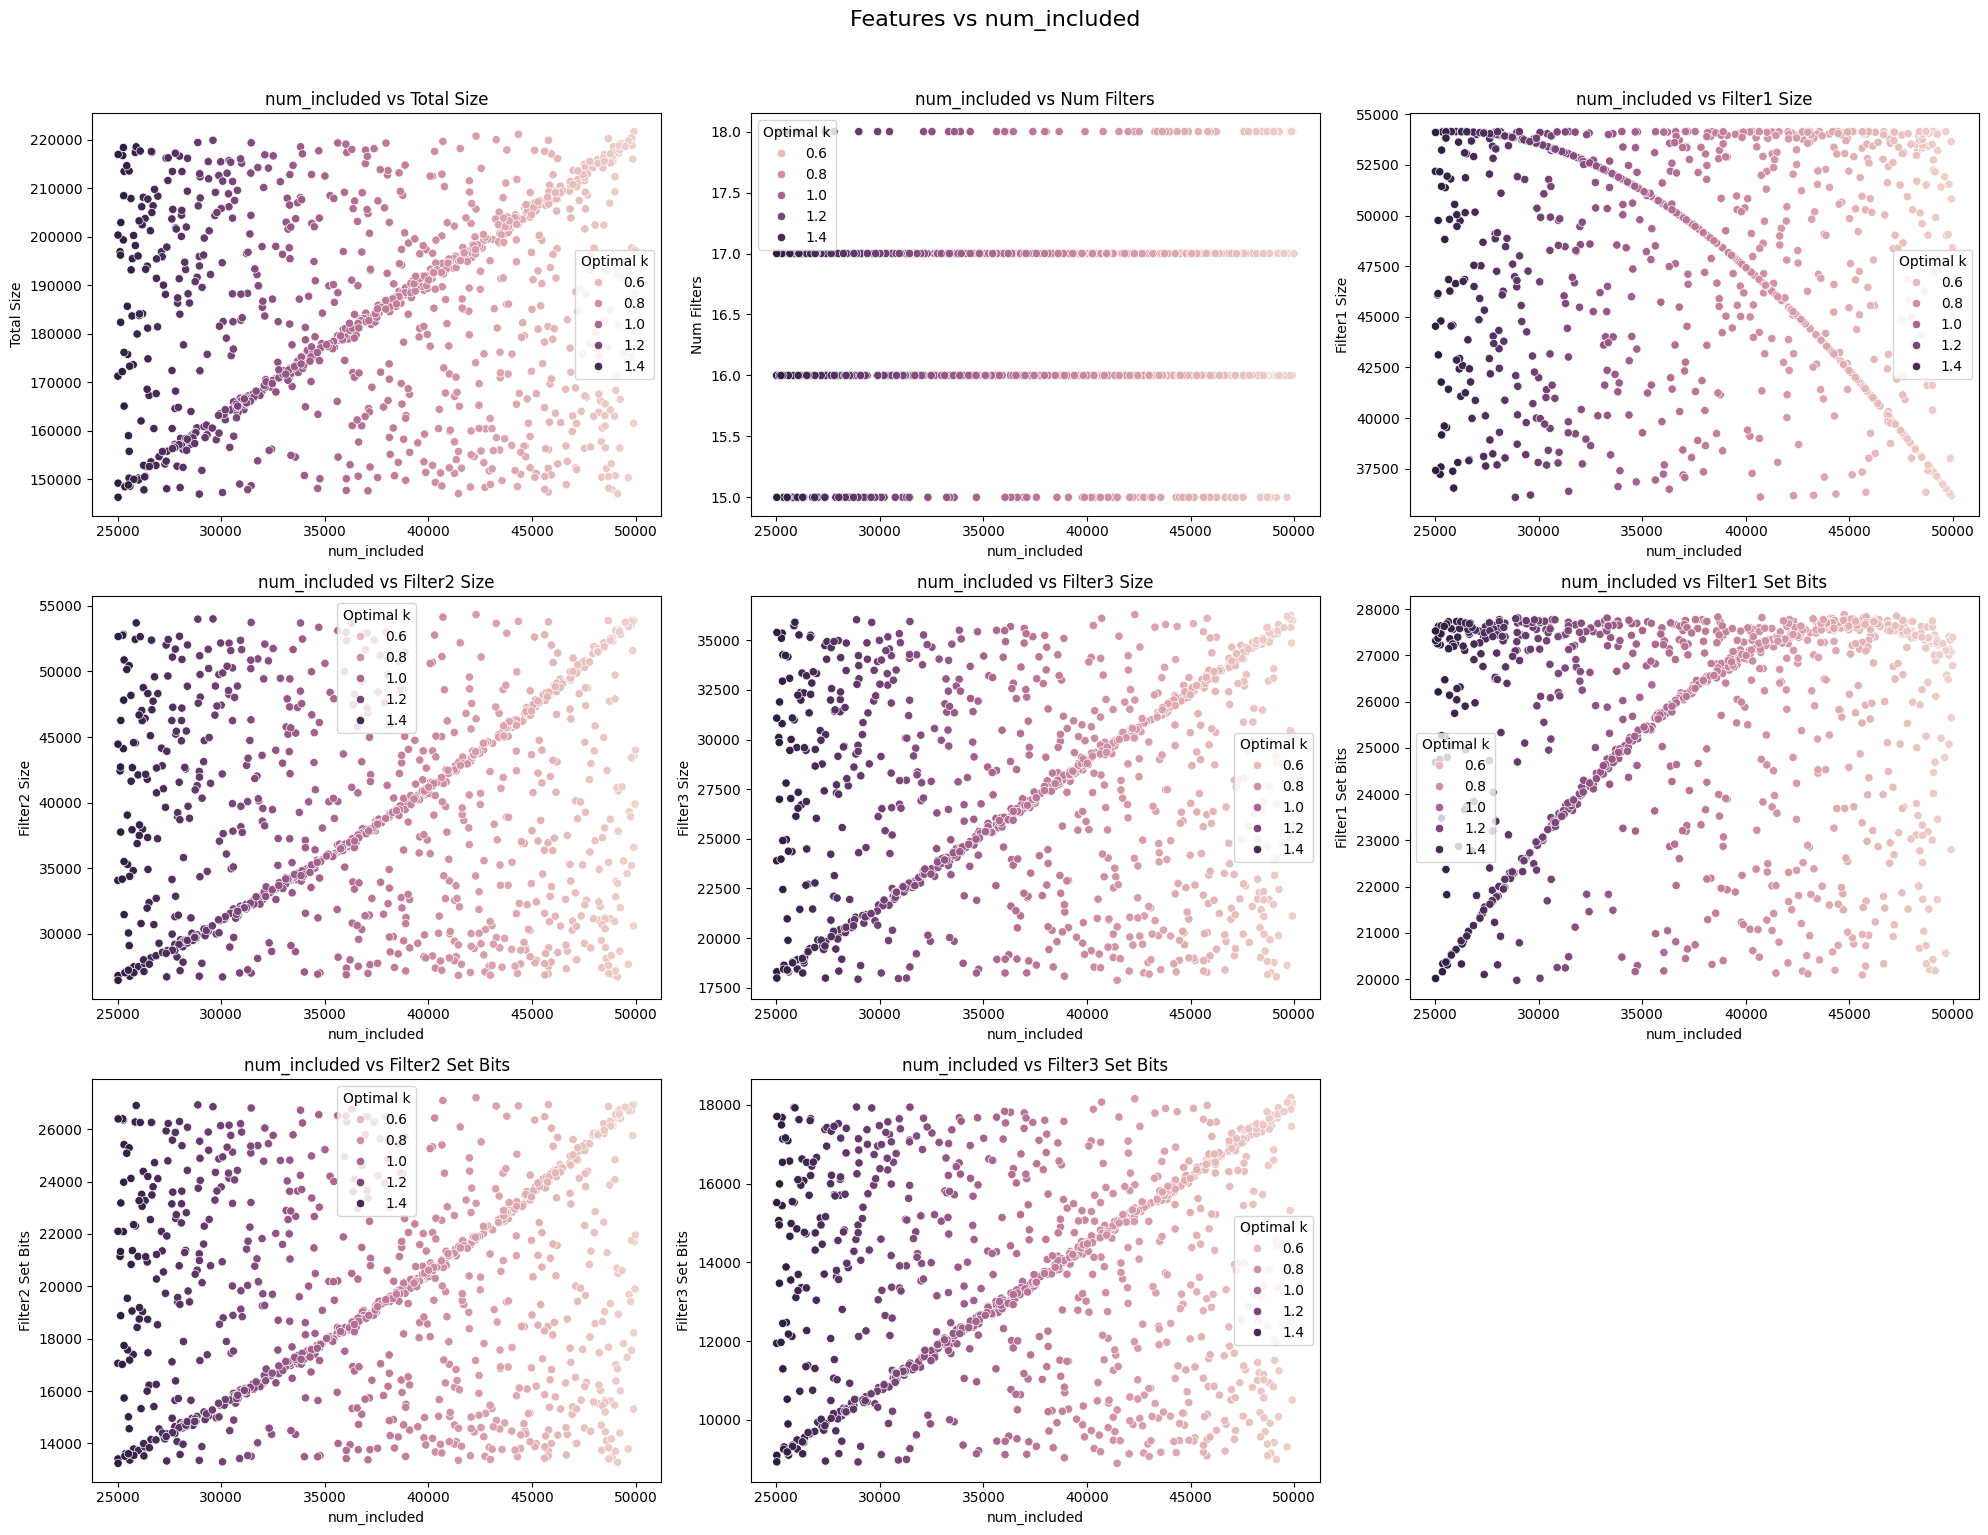

In [6]:
plt.figure(figsize=(20, 15))
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Features vs num_included', size=16, y=1.02)

# Flatten axes for easier iteration
axes = axes.ravel()

# Create scatter plot for each feature
for idx, feature in enumerate(feature_names[:-1]):
    sns.scatterplot(
        data=df,
        x=r,
        y=feature,
        ax=axes[idx],
        alpha=1.0,
        hue='Optimal k',
    )
    axes[idx].set_title(f'num_included vs {feature}')
    axes[idx].set_xlabel('num_included')
    axes[idx].set_ylabel(feature)

# Remove the empty subplot (since we have 8 features and 9 subplots)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()